# Stance Detection Using Multi-Layer Perceptron


`Multi-Layer Perceptron`  
`AraStance Dataset`  
`Stance Detection` `Arabic Language`

---

In this notebook, we rely on very simple multi-layer perceptron to classify the stances of the articles in the AraStance dataset. The dataset was introduced in the paper:  
```
AraStance: A Multi-Country and Multi-Domain Dataset of Arabic Stance Detection for Fact Checking.
```
The perceptron we experiment with is inspired by the paper:
```
A simple but tough-to-beat baseline for the Fake News Challenge stance detection task
```

## Packages

In [ ]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from utils import AraStanceData, load_stop_words, stance_to_int, evaluate

## Raw data

- Download the raw data:

In [ ]:
!wget https://github.com/Tariq60/arastance/archive/refs/heads/main.zip
!unzip /content/main.zip

- Let's start by reading the raw data:

In [ ]:
raw_train = AraStanceData("/content/arastance-main/data/train.jsonl")
raw_dev = AraStanceData("/content/arastance-main/data/dev.jsonl")
raw_test = AraStanceData("/content/arastance-main/data/test.jsonl")

print(f'# training instances: {len(raw_train.stances)}')
print(f'# validation instances: {len(raw_dev.stances)}')
print(f'# testing instances: {len(raw_test.stances)}')

# training instances: 2848
# validation instances: 569
# testing instances: 646


- Let's see an instance from the data:

In [ ]:
instance_no = 10
print(f"Claim text: {raw_train.claims[raw_train.article_claim[instance_no]]}")
print(f"Article text: {raw_train.articles[instance_no]}")
print(f"Stance: {raw_train.stances[instance_no]}")

Claim text: العثور على طلاسم سحرية على ستار الكعبة المشرفة
Article text: نفت الرئاسة العامة لشؤون المسجد الحرام والمسجد النبوي، ما تردد عن وجود سحر وطلاسم في ثوب الكعبة، مؤكدة أن ما عثر عليه هو ورقة تركها أحد الزوار تضمنت أدعية ظنًا منه أنها ستجلب له الخير. وكان عدد من منسوبي الرئاسة العامة لشؤون المسجد الحرام والمسجد النبوي قد عثروا على ورقة صغيرة الحجم موضوعة بطريقة مريبة بين خيوط إطار ثوب الكعبة المشرفة السفلي، فيما رجح مغردون أنها تتضمن سحرًا أو طلاسم. وأكد مصدر بالرئاسة العامة لشؤون الحرمين في تصريحات صحافية أنه تم تلقي بلاغ من منسوبي صيانة الكسوة عن وجود ورقة في أحد إطارات الكعبة المشرفة مصاغة بطريقة مريبة بخيوط الكعبة، حيث بادرت إدارة الهيئة بالمسجد الحرام هذا البلاغ وتم أخذ هذه الورقة التي لم يتضح أن بها سحر . وكان مغردون قد تداولوا مقطع فيديو يظهر لحظة العثور على الورقة في ثوب الكعبة مرجحين أنها سحر، داعين إلى سرعة التحقيق في الأمر وكشف الحقائق للناس.
Stance: Disagree


- Thus, the instances are triplets, Claim/Article/Stance.
- Note that the original language of the data is Arabic.

## Dataset

- First, we need to vectorize the data. To do so, we'll use tf-idf vectors to represent the instances:

In [ ]:
# lim_unigram is the size of the vocabulary or
# the top features ordered by term frequency across the corpus
lim_unigram = 4000
batch_size = 512

In [ ]:
nltk_stop_words, custom_stop_words = load_stop_words()
stop_words = nltk_stop_words + custom_stop_words

# to fit the vectorizer, we will only use the training data.
# Now, concatenate the pairs claims/articles
train_instances = [raw_train.claims[raw_train.article_claim[idx]] + " " + article \
                  for idx, article in enumerate(raw_train.articles)]

# fit the vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=lim_unigram, stop_words=stop_words)
tfidf_vectorizer = tfidf_vectorizer.fit(train_instances)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


- Now the vectorizer is fitted, we can start vectorizing the data:

In [ ]:
# we will use this function to vectorize the data using the fitted vectorizer
def vectorize(data):
  feature_vectors = []

  for idx in range(len(data.articles)):
    claim = data.claims[data.article_claim[idx]]
    article = data.articles[idx]

    # vectorize the pair into (lim_unigram,) sparse vectors each
    claim_tfidf = tfidf_vectorizer.transform([claim]).toarray()
    article_tfidf = tfidf_vectorizer.transform([article]).toarray()

    # find the similarity between claim and article vectors
    similarity = cosine_similarity(claim_tfidf, article_tfidf)

    # append the vectors and the similarity to construct (2 * lim_unigram + 1) vector
    feat_vec = np.squeeze(np.c_[claim_tfidf, article_tfidf, similarity])
    feature_vectors.append(tf.constant(feat_vec))

  return feature_vectors

train_features = vectorize(raw_train)
dev_features = vectorize(raw_dev)
test_features = vectorize(raw_test)

- Let's see a vectorized instance from the training data:

In [ ]:
instance_no = 10
print(f'shape of each feature vector is: {train_features[instance_no].shape}')
print(f'feature vectors are sparse: {train_features[instance_no]}')

shape of each feature vector is: (8001,)
feature vectors are sparse: [0.         0.         0.         ... 0.         0.         0.50467087]


- As you can see the representations are sparse and contain `2 * lim_unigram + 1` features.

- Now the features are ready, we can create the datasets we are going to use for the training and testing:

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_size = len(raw_train.stances)
dev_size = len(raw_dev.stances)

train_labels = [stance_to_int[s] for s in raw_train.stances]
train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels))
train_dataset = train_dataset.shuffle(train_size)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)

dev_labels = [stance_to_int[s] for s in raw_dev.stances]
dev_dataset = tf.data.Dataset.from_tensor_slices((dev_features, dev_labels))
dev_dataset = dev_dataset.batch(batch_size)
dev_dataset = dev_dataset.cache().prefetch(buffer_size=AUTOTUNE)

test_labels = [stance_to_int[s] for s in raw_test.stances]
test_dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels))
test_dataset = test_dataset.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)

- Let's see a batch from the training dataset:

In [ ]:
batch, labels = next(iter(train_dataset))
print(f'shape of the batch is: {batch.shape}')
print(f'batch instances: {batch.numpy()}')
print(f'batch labels: {labels.numpy()}')

shape of the batch is: (512, 8001)
batch instances: [[0.         0.         0.         ... 0.         0.         0.13691706]
 [0.         0.         0.         ... 0.         0.         0.57642169]
 [0.         0.         0.         ... 0.         0.         0.10792191]
 ...
 [0.         0.         0.         ... 0.         0.         0.2458291 ]
 [0.         0.         0.         ... 0.         0.         0.08743462]
 [0.         0.         0.         ... 0.         0.         0.04405263]]
batch labels: [0 0 3 3 3 1 3 2 3 3 3 1 3 1 0 0 3 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3
 0 3 2 0 1 1 0 3 3 3 0 3 3 0 1 3 0 0 1 3 2 3 3 0 3 1 3 3 2 2 3 3 1 1 0 3 1
 3 3 2 2 3 0 3 3 3 3 3 3 3 0 2 3 0 0 3 3 1 3 3 3 3 3 0 3 0 3 2 3 3 0 3 2 0
 0 3 3 3 0 3 3 3 1 2 3 0 3 3 0 3 0 1 2 3 2 3 0 2 3 0 2 3 3 0 3 3 3 0 2 3 1
 0 0 3 3 0 0 3 3 2 0 3 3 3 3 3 1 3 0 1 1 3 3 3 3 0 0 3 1 3 3 2 0 0 0 3 1 0
 2 1 1 3 0 0 3 3 3 3 0 3 1 2 3 1 3 3 1 3 0 0 2 3 0 3 3 0 3 3 2 0 0 0 3 3 3
 2 3 0 3 3 3 3 3 3 0 0 1 3 3 3 1 3 3 0 3

## Model

- Now the datasets are ready, we can work on the model:

In [ ]:
def create_model(lr):
  inputs = tf.keras.Input(shape=(2*lim_unigram+1,), dtype=tf.float32)
  outputs = tf.keras.layers.Dense(4)(inputs)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
    )

  return model

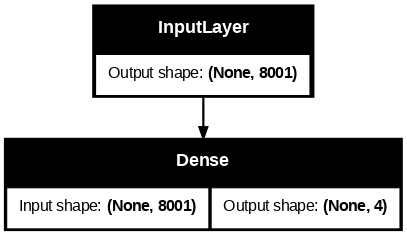

In [ ]:
plotting_model = create_model(lr=0.)
tf.keras.utils.plot_model(plotting_model, show_shapes=True, dpi=80)

In [ ]:
plotting_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 8001)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │          32,008 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,008 (125.03 KB)

 Trainable params: 32,008 (125.03 KB)

 Non-trainable params: 0 (0.00 B)

## Training & Evaluation

In [ ]:
reps = 5
lr = 6e-2
epochs = 100
patience = 3

histories = []
val_accuracy, val_f1score, val_mf1score = [], [], []
test_accuracy, test_f1score, test_mf1score = [], [], []
for _ in range(reps):
  model = create_model(lr)

  callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)]
  history = model.fit(
      x=train_dataset,
      validation_data=dev_dataset,
      epochs=epochs,
      callbacks=callbacks)
  histories.append(history)

  _, accuracy, f1score, mf1score = evaluate(model, dev_dataset, dev_labels)
  val_accuracy.append(accuracy)
  val_f1score.append(f1score)
  val_mf1score.append(mf1score)

  _, accuracy, f1score, mf1score = evaluate(model, test_dataset, test_labels)
  test_accuracy.append(accuracy)
  test_f1score.append(f1score)
  test_mf1score.append(mf1score)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.4570 - loss: 1.1355 - val_accuracy: 0.6362 - val_loss: 1.0476
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8098 - loss: 0.5604 - val_accuracy: 0.7118 - val_loss: 0.8074
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8966 - loss: 0.3577 - val_accuracy: 0.7417 - val_loss: 0.7620
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9247 - loss: 0.2656 - val_accuracy: 0.7575 - val_loss: 0.7530
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9418 - loss: 0.2080 - val_accuracy: 0.7733 - val_loss: 0.7500
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9585 - loss: 0.1704 - val_accuracy: 0.7733 - val_loss: 0.7386
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9675 - loss: 0.1423 - val_accuracy: 0.7786 - val_loss: 0.7383
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9715 - loss: 0.1217 - val_accuracy: 0.7768 - val_loss:

**Overfitting Analysis**  
The gap between training and validation performance indicates that the model is overfitting the training data. Several factors contribute to this issue:
1. **Insufficient Data**: The relatively small training dataset of 2848 instances is insufficient for the model to learn the intricate nuances of the task, particularly given its inherent complexity.
2. **Task Complexity:** The 'disagree' and 'discuss' classes pose significant challenges due to their subtle distinctions. While 'unrelated' and 'agree' classes can often be identified through simple textual similarity, 'disagree' and 'discuss' require deeper semantic understanding and the ability to detect complex linguistic cues:
   - **Discuss class:** Discussing involves giving more details and different viewpoints.
   - **Disagree class:** Disagreement could involve simple negation terms or more complex negations like changing dates, quantities, or introducing opposing concepts (e.g. Sky is Blue vs. Sky is Black).

3. **Annotation Errors:** Manual inspection has revealed a non-negligible number of misannotations, further complicating the learning process.
4. **Language Challenges:** Arabic, the language of the dataset, presents additional complexities due to its rich morphology and diverse dialects.
5. **Class Imbalance:** The 'unrelated' class significantly outnumbers the other classes. Additionally, the 'disagree' and 'discuss' classes are underrepresented compared to the 'agree' and 'unrelated' classes. The relative lower representations of the 'discuss' and 'disagree' classes across the three sets exacerbates the classification challenge.

![image not found](tab_arastance.png)

**Mitigating Overfitting**  
While regularization techniques and early stopping may have limited effectiveness, addressing the underlying data limitations is crucial:
1. **Data Augmentation:** Explore techniques like back-translation, synonym replacement, and text generation to artificially expand the dataset.
2. **Transfer Learning:** Leverage pre-trained language models to incorporate prior knowledge and improve generalization.
3. **Ensemble Methods:** Combine multiple models to reduce variance and improve overall performance.



### Results

In [ ]:
print("Validation Resutls:")
print("=====================")
print(f"Mean Accuracy: {np.mean(val_accuracy):.3f}")
agree, disagree, discuss, unrelated = np.mean(val_f1score, axis=0)
print("Mean Per Class F1 scores:")
print(f"Agree   : {agree:.3f}")
print(f"Disagree: {disagree:.3f}")
print(f"Discuss : {discuss:.3f}")
print(f"Unrelated: {unrelated:.3f}")
print(f"Mean Macro F1 scores: {np.mean(val_mf1score):.3f}")

Validation Resutls:
Mean Accuracy: 0.781
Mean Per Class F1 scores:
Agree   : 0.760
Disagree: 0.738
Discuss : 0.513
Unrelated: 0.846
Mean Macro F1 scores: 0.714


In [ ]:
print("Testing Resutls:")
print("=====================")
print(f"Mean Accuracy: {np.mean(test_accuracy):.3f}")
agree, disagree, discuss, unrelated = np.mean(test_f1score, axis=0)
print("Mean Per Class F1 scores:")
print(f"Agree   : {agree:.3f}")
print(f"Disagree: {disagree:.3f}")
print(f"Discuss : {discuss:.3f}")
print(f"Unrelated: {unrelated:.3f}")
print(f"Mean Macro F1 scores: {np.mean(test_mf1score):.3f}")

Testing Resutls:
Mean Accuracy: 0.824
Mean Per Class F1 scores:
Agree   : 0.818
Disagree: 0.767
Discuss : 0.425
Unrelated: 0.886
Mean Macro F1 scores: 0.724
